## Test Marqo Model

In [1]:
from transformers import AutoModel, AutoProcessor
import torch
from PIL import Image
import requests
from train.marqo_fashionSigLIP import Marqo_fashionSigLIP, Marqo_fashionSigLIPConfig

model_name = "/ssd2/hutu_data/MMRetrieval/model/Marqo/marqo-ecommerce-embeddings-L"
# model_name = 'Marqo/marqo-ecommerce-embeddings-B'

model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

img = Image.open(
    requests.get(
        "https://raw.githubusercontent.com/marqo-ai/marqo-ecommerce-embeddings/refs/heads/main/images/dining-chairs.png",
        stream=True,
    ).raw
).convert("RGB")
image = [img]
text = ["dining chairs", "a laptop", "toothbrushes"]
processed = processor(
    text=text, images=image, padding="max_length", return_tensors="pt"
)
processor.image_processor.do_rescale = False
with torch.no_grad():
    image_features = model.get_image_features(processed["pixel_values"], normalize=True)
    text_features = model.get_text_features(processed["input_ids"], normalize=True)

    text_probs = (100 * image_features @ text_features.T).softmax(dim=-1)

print(text_probs)
# [1.0000e+00, 8.3131e-12, 5.2173e-12]


/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type siglip to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


tensor([[1.0000e+00, 8.3130e-12, 5.2174e-12]])


In [13]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class ShopeeDataset(Dataset):
    def __init__(self, df, img_dir, split: str = "train"):
        self.df = df
        self.img_dir = img_dir
        self.transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                # convert to RGB
                transforms.Lambda(lambda img: img.convert("RGB")),
                transforms.ToTensor(),
            ]
        )
        self.split = split
        self.len = len(self.df)
        # self.imgs = self._read_all_images()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        if self.split == "train":
            query_text = row["query"]
            pos_text = row["pos_txt"][0]
            neg_text = row["neg_txt"][0]

            query_img_path = os.path.join(self.img_dir, row["image"])
            pos_img_path = os.path.join(self.img_dir, row["pos_img"][0])
            neg_img_path = os.path.join(self.img_dir, row["neg_img"][0])

            query_img = self._get_image(query_img_path)
            pos_img = self._get_image(pos_img_path)
            neg_img = self._get_image(neg_img_path)

            return {
                "query": {
                    "text": query_text,
                    "image": query_img,
                },
                "pos": {
                    "text": pos_text,
                    "image": pos_img,
                },
                "neg": {
                    "text": neg_text,
                    "image": neg_img,
                },
            }

        elif self.split == "valid":
            title = row["title"]
            image_path = os.path.join(self.img_dir, row["image"])

            img = self._get_image(image_path)
            pil_img = Image.open(image_path)

            return {
                "title": title,
                "image": img,
                "pil_image": pil_img,
                "image_path": image_path,
            }

    def _get_image(self, path):
        img = Image.open(path)
        img = self.transform(img)
        return img

    def get_pil_image(self, path):
        return Image.open(path)


def get_collate_fn(processor):
    def collate_fn(batch):
        images = [item["image"] for item in batch]
        texts = [item["title"] for item in batch]

        processed = processor(
            text=texts,
            images=images,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        processor.image_processor.do_rescale = False

        return processed

    return collate_fn


def visualize(df, index, col):
    """可视化图片和预测结果，预测结果为posting_id的list"""
    row = df.iloc[index]
    preds = row[col]
    img_dir: str = "../data/train_images"
    images = [df[df.posting_id == pred].image.values[0] for pred in preds]

    target_title = row.title
    target_img = row.image

    titles = [df[df.posting_id == pred].title.values[0] for pred in preds]
    images = [Image.open(os.path.join(img_dir, img)) for img in images]

    rows = 5
    cols = 5
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

    plt.axis("off")

    for i in range(cols):
        ax[0, i].axis("off")

    for i in range(rows):
        ax[i, 0].axis("off")

    ax[0, 0].imshow(Image.open(os.path.join(img_dir, target_img)))
    ax[0, 0].set_title(
        "\n".join([target_title[i : i + 10] for i in range(0, len(target_title), 10)]),
        fontsize=12,
    )

    for i in range(1, rows):
        for j in range(1, cols):
            idx = (i - 1) * cols + (j - 1)
            ax[i, j].axis("off")
            if idx < len(images):
                ax[i, j].imshow(images[idx])
                ax[i, j].set_title(
                    "\n".join(
                        [
                            titles[idx][k : k + 10]
                            for k in range(0, len(titles[idx]), 10)
                        ]
                    ),
                    fontsize=12,
                )


def compute_f1(col):
    def f1(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return 2 * n / (len(row["label"]) + len(row[col]))

    return f1


def compute_recall(col):
    def recall(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return n / len(row["label"])

    return recall


def compute_precision(col):
    def precision(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return n / len(row[col])

    return precision


def compute_precision_K(col, K):
    def precision(row):
        n = len(np.intersect1d(row["label"], row[col][:K]))
        return n / K

    return precision


def compute_AP(col, N):
    """compute average precision"""

    def AP(row):
        n = len(np.intersect1d(row["label"], row[col]))
        max_n = min(len(row[col]), N)
        if n == 0:
            return 0
        return (
            sum(
                [
                    compute_precision_K(col, i)(row)
                    for i in range(1, max_n + 1)
                    if row[col][i - 1] in row["label"]
                ]
            )
            / max_n
        )

    return AP


def retrieval(embs, df, chunk_size=4096, threshold=None, topK=None):
    assert (
        threshold is not None or topK is not None
    ), "Either threshold or topK should be provided"
    assert (
        threshold is None or topK is None
    ), "Only one of threshold or topK should be provided"

    embs_pt = torch.tensor(embs).cuda()

    num_chunks = (embs_pt.shape[0] + chunk_size - 1) // chunk_size
    posting_id = df.posting_id.to_list()
    topk_posting_id = []

    print(f"Chunk Size: {chunk_size}, {num_chunks} chunks")

    for i in tqdm(range(num_chunks)):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, embs_pt.shape[0])
        sim = embs_pt[start:end] @ embs_pt.T

        if topK is not None:
            indices = torch.topk(sim, topK, dim=1).indices.cpu().numpy()
            topk_posting_id.extend([[posting_id[j] for j in row] for row in indices])
        elif threshold is not None:
            mask = sim > threshold
            indices = [
                torch.nonzero(mask[j]).squeeze().cpu().numpy()
                for j in range(mask.shape[0])
            ]
            indices = [np.unique(i) for i in indices]
            sorted_indices = [
                indices[j][np.argsort(-sim[j, indices[j]].cpu().numpy())]
                for j in range(len(indices))
            ]
            topk_posting_id.extend(
                [[posting_id[j] for j in row] for row in sorted_indices]
            )

    # clean up
    del embs_pt
    torch.cuda.empty_cache()

    return topk_posting_id

In [6]:
from torch.utils.data import DataLoader

df = pd.read_csv("/ssd2/hutu_data/MMRetrieval/data/train.csv")
img_dir = "/ssd2/hutu_data/MMRetrieval/data/train_images"
split = "valid"

dataset = ShopeeDataset(df, img_dir, split)
collate_fn = get_collate_fn(processor)

dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=False,
    num_workers=16,
    collate_fn=collate_fn,
)

In [7]:
from tqdm import tqdm
from torch.nn.parallel import DataParallel

embs = []

model.eval()
model.cuda()
for batch in tqdm(dataloader):
    with torch.no_grad():
        for k, v in batch.items():
            batch[k] = v.cuda() if isinstance(v, torch.Tensor) else v

        image_features = model.get_image_features(batch["pixel_values"], normalize=True)
        text_features = model.get_text_features(batch["input_ids"], normalize=True)
        emb = torch.cat((image_features, text_features), dim=1).detach().cpu().numpy()
        emb /= np.linalg.norm(emb, axis=1, keepdims=True)

        embs.append(emb)

embs = np.concatenate(embs, axis=0)

del model, processor
torch.cuda.empty_cache()

  0%|          | 0/268 [00:00<?, ?it/s]

100%|██████████| 268/268 [11:18<00:00,  2.53s/it]


In [20]:
threshold = 0.73

for threshold in np.linspace(0.7, 0.8, 20):
    df["marqo"] = retrieval(embs, df, threshold=threshold, chunk_size=4096)

    tmp = df.groupby("label_group").posting_id.agg("unique").to_dict()
    df["label"] = df.label_group.map(tmp)

    df["f1"] = df.apply(compute_f1("marqo"), axis=1)
    df["recall"] = df.apply(compute_recall("marqo"), axis=1)
    df["precision"] = df.apply(compute_precision("marqo"), axis=1)
    df["AP"] = df.apply(compute_AP("marqo", 50), axis=1)

    print(f"Threshold: {threshold}")
    print(f"F1: {df.f1.mean()}")
    print(f"Recall: {df.recall.mean()}")
    print(f"Precision: {df.precision.mean()}")
    print(f"AP@50: {df.AP.mean()}")

Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Threshold: 0.7
F1: 0.7169647374845208
Recall: 0.795884466370229
Precision: 0.7735901347598954
AP@50: 0.7573664985858611
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Threshold: 0.7052631578947368
F1: 0.7187709620724564
Recall: 0.7865879581124741
Precision: 0.784861748407794
AP@50: 0.7690172115638317
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Threshold: 0.7105263157894737
F1: 0.719261026584141
Recall: 0.7762644496723073
Precision: 0.7955363597300315
AP@50: 0.7801449006479033
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Threshold: 0.7157894736842105
F1: 0.7196866683024714
Recall: 0.7666080677198087
Precision: 0.8057309016051687
AP@50: 0.790750050630171
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Threshold: 0.7210526315789474
F1: 0.7192852393164043
Recall: 0.7560857740317395
Precision: 0.8156253588031387
AP@50: 0.8011834829737046
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Threshold: 0.7263157894736842
F1: 0.7186384480599174
Recall: 0.7457465974982777
Precision: 0.8249582706438212
AP@50: 0.8110481806687196
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Threshold: 0.731578947368421
F1: 0.7172893970608133
Recall: 0.7350750017649776
Precision: 0.8343020518607385
AP@50: 0.8209321021914432
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Threshold: 0.7368421052631579
F1: 0.7152764785030209
Recall: 0.7241004845005373
Precision: 0.8433488082475828
AP@50: 0.8304967001413958
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Threshold: 0.7421052631578947
F1: 0.712962077786829
Recall: 0.7131764583922348
Precision: 0.852101582038237
AP@50: 0.8397547496367089
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Threshold: 0.7473684210526316
F1: 0.7098302533255314
Recall: 0.701629992234831
Precision: 0.8603002299598621
AP@50: 0.8485134584214421
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Threshold: 0.7526315789473684
F1: 0.7071666353761321
Recall: 0.6910442549773947
Precision: 0.8685255897126551
AP@50: 0.8572700927540395
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Threshold: 0.7578947368421053
F1: 0.7036068685427203
Recall: 0.6796093630959976
Precision: 0.8766725053200505
AP@50: 0.8659962409045953
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Threshold: 0.7631578947368421
F1: 0.6997811820637623
Recall: 0.6680822788743963
Precision: 0.8846081044922602
AP@50: 0.874467701823307
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Threshold: 0.768421052631579
F1: 0.6950265598159973
Recall: 0.6561932638994019
Precision: 0.8916702871143385
AP@50: 0.8821038400875185
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Threshold: 0.7736842105263159
F1: 0.6900583716208273
Recall: 0.6442327305096911
Precision: 0.8986459683524899
AP@50: 0.8897013823594487
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Threshold: 0.7789473684210526
F1: 0.6843672193132879
Recall: 0.6323770751805847
Precision: 0.9045798243331911
AP@50: 0.8961970885576535
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Threshold: 0.7842105263157895
F1: 0.679186483685718
Recall: 0.6208644513814803
Precision: 0.9111957662665067
AP@50: 0.9033301009853701
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Threshold: 0.7894736842105263
F1: 0.6736171310978947
Recall: 0.609369302758944
Precision: 0.9171607751705312
AP@50: 0.9098511764236253
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Threshold: 0.7947368421052632
F1: 0.6677822382282269
Recall: 0.5979581829694158
Precision: 0.9231546260525504
AP@50: 0.916388452383332
Chunk Size: 4096, 9 chunks


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Threshold: 0.8
F1: 0.6613172582655243
Recall: 0.5861262613440177
Precision: 0.9287398730120594
AP@50: 0.9224312239064552


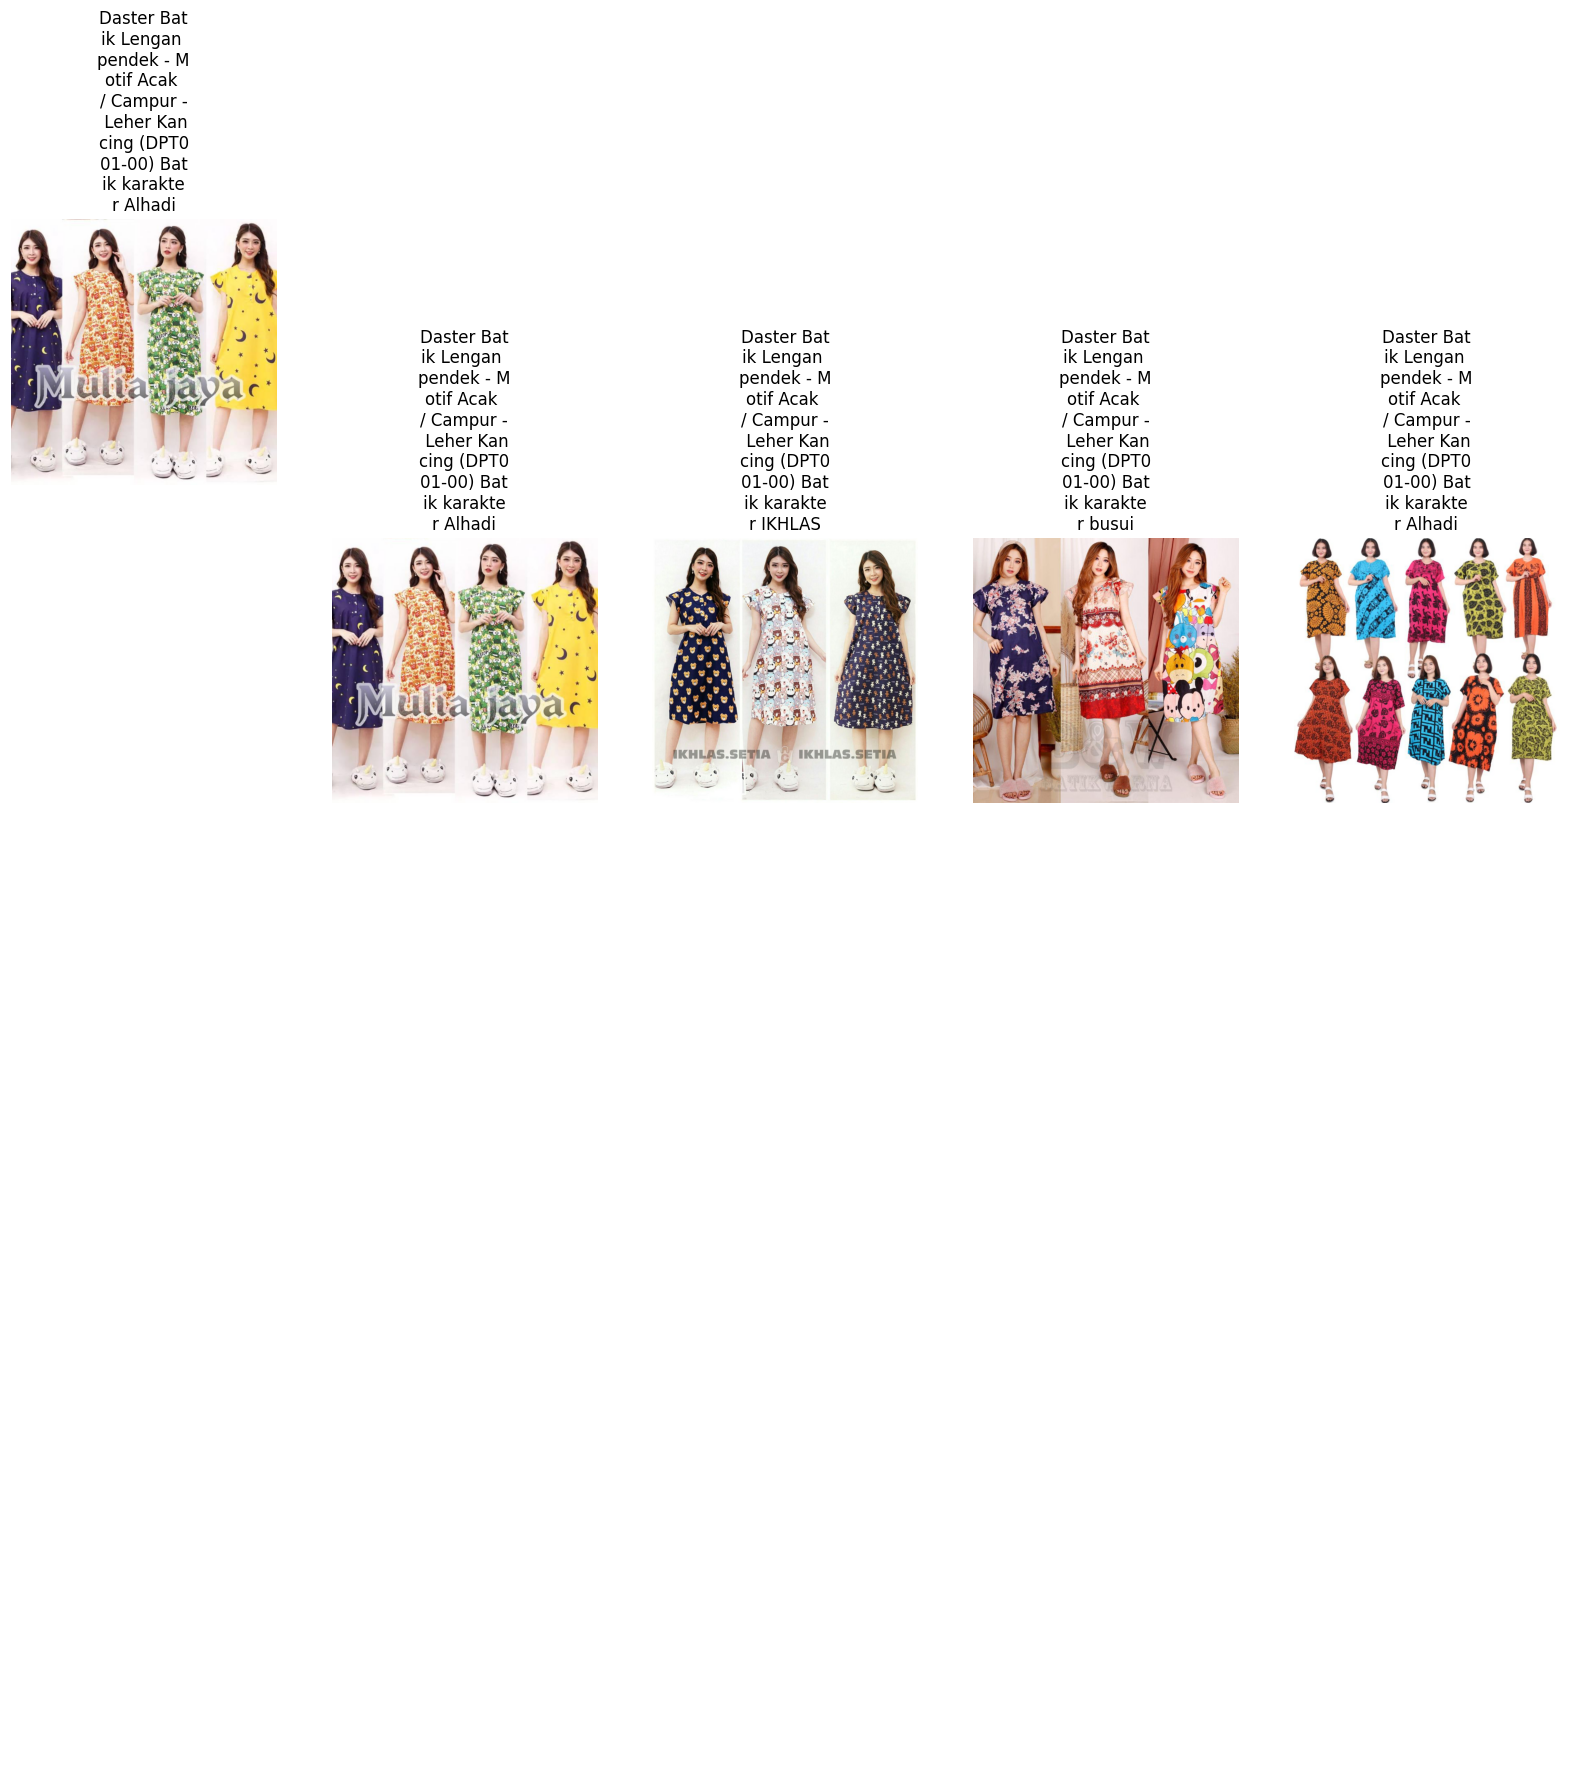

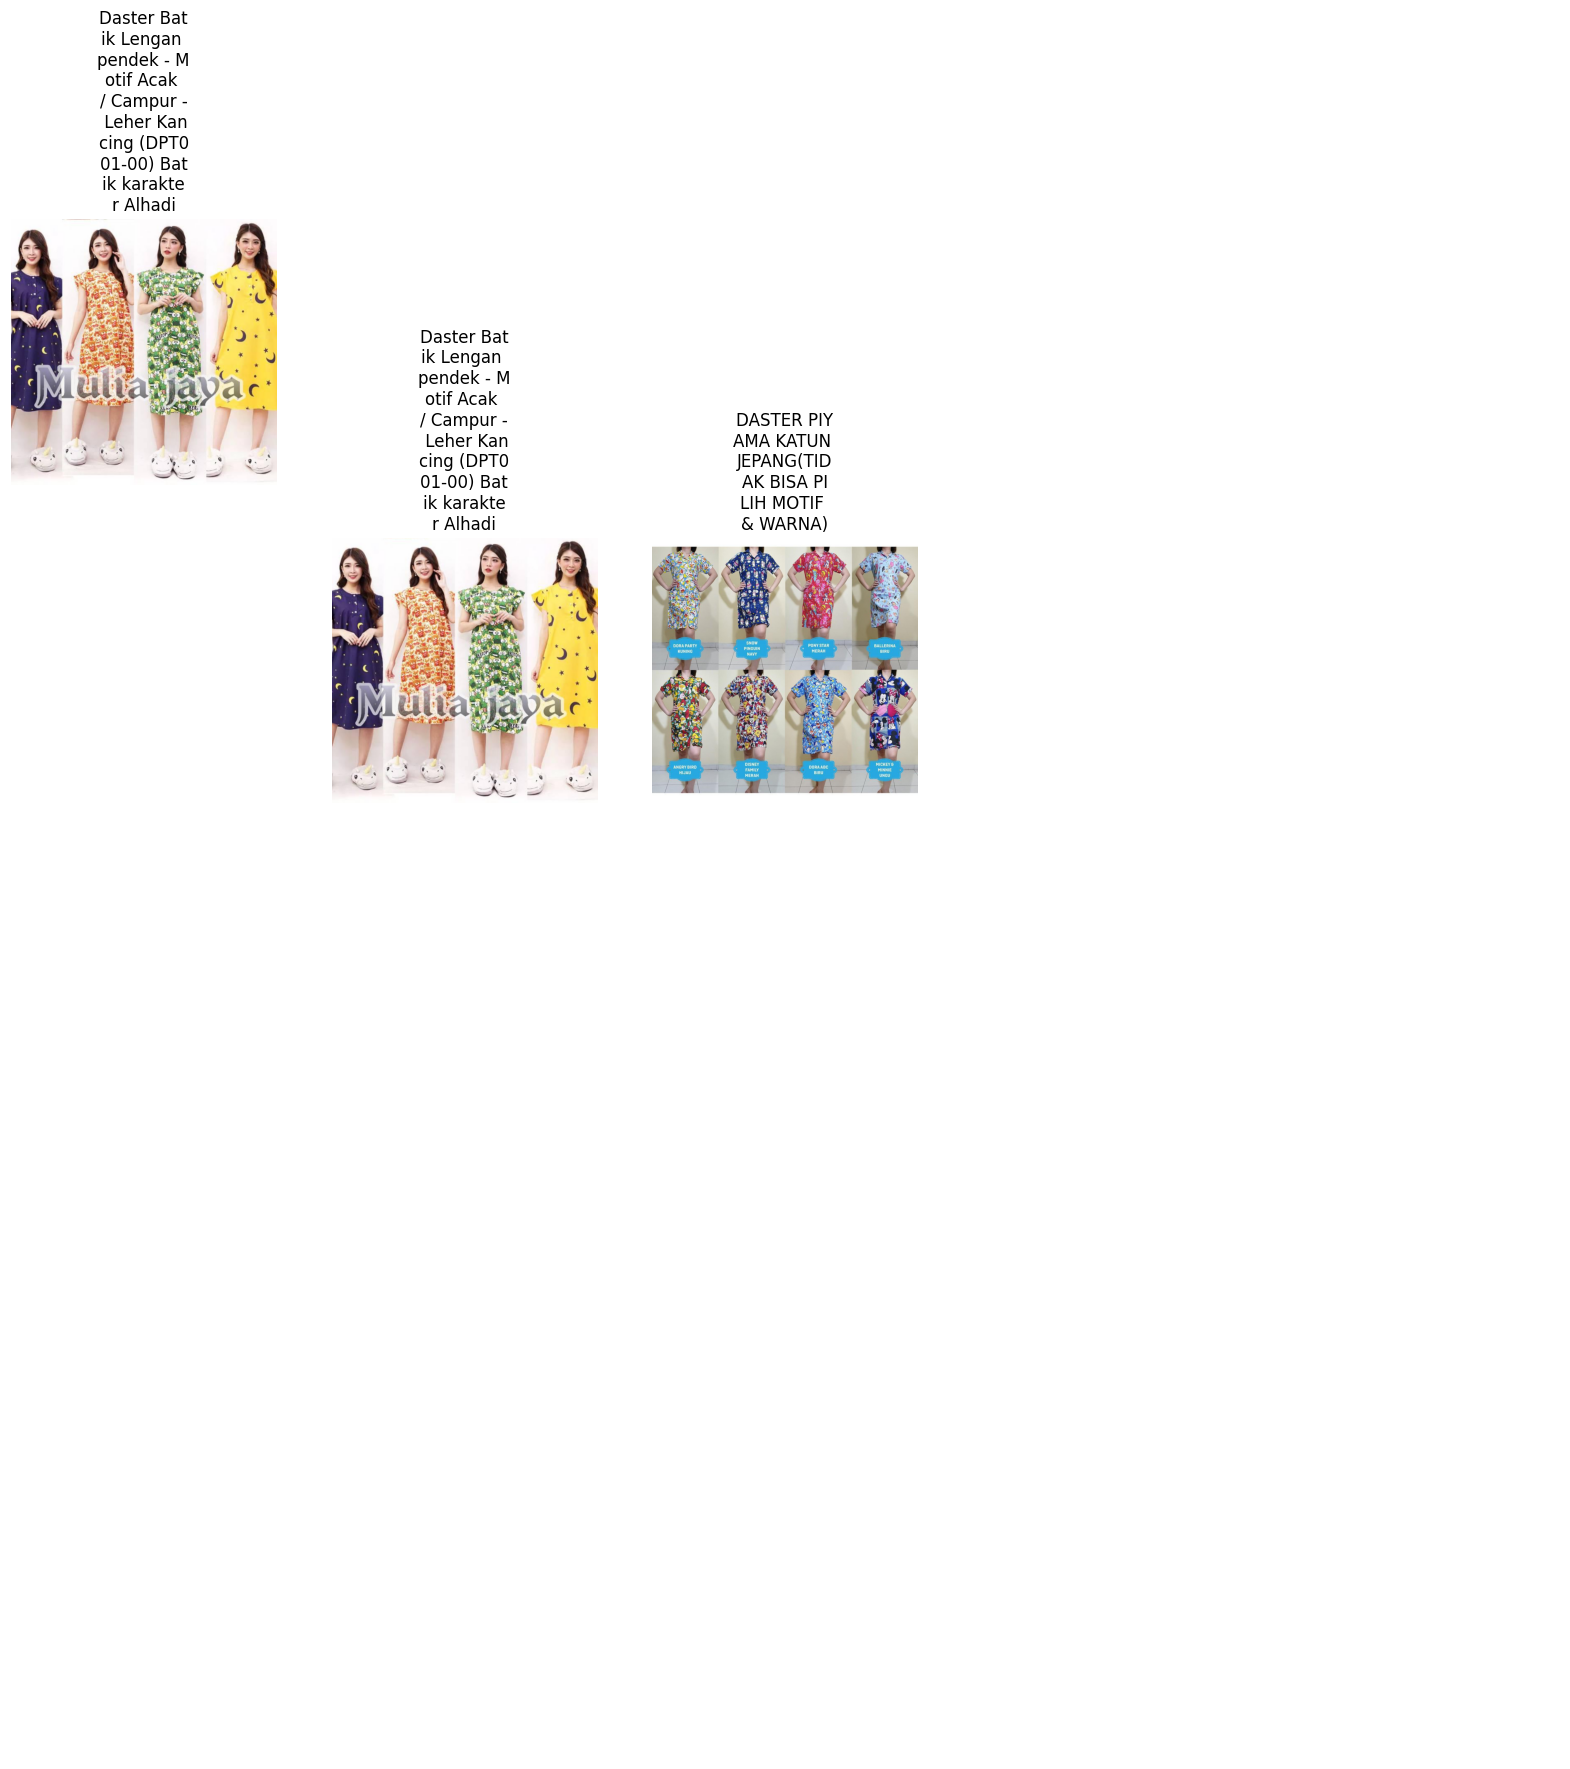

In [19]:
import matplotlib.pyplot as plt

index = 1
samples = df[df["f1"] < 0.6].index.to_list()
visualize(df, samples[index], "marqo")
visualize(df, samples[index], "label")